In [1]:
from classes.Backtest import PositionGenerator, Config, Frequency, Backtester, StatPtf
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Alexandre\Documents\Cour_Dauphine\POO\POO_DHENIN_MANELLI\classes\Backtest.py:13: UserWarning: Running this module requires the package: polars 0.15.14
  warn('Running this module requires the package: polars 0.15.14')


In [2]:
path = "dataset.csv"
random_position = PositionGenerator(path, random_=True)
all_stock_position = PositionGenerator(path, all_stock=True)
pos = PositionGenerator(path)

In [3]:
raw = pd.read_csv("raw_dataset.csv")
raw.Date = pd.to_datetime(raw.Date)

positions = pos.compute_positions()
all_stock = all_stock_position.compute_positions()
random_ = random_position.compute_positions()
raw = raw.loc[raw['Date'].isin(positions.Date)]
raw = pl.convert.from_pandas(raw)

In [4]:
conf = Config(
    universe=raw.columns[1:],
    start_ts=positions.Date.iloc[0],
    end_ts=positions.Date.iloc[-1],
    strategy_code='LSTM',
    frequency=Frequency.DAILY,
    timeserie=raw,
)

In [5]:
backtester = Backtester(conf, timeserie=raw, y_pred=pl.convert.from_pandas(positions))
strat_ptf = pd.DataFrame(backtester.compute_levels()) 

In [6]:
conf = Config(
    universe=raw.columns[1:],
    start_ts=positions.Date.iloc[0],
    end_ts=positions.Date.iloc[-1],
    strategy_code='all_stock',
    frequency=Frequency.DAILY,
    timeserie=raw,
)
backtester1 = Backtester(conf, timeserie=raw, y_pred=pl.convert.from_pandas(all_stock))
all_stock_ptf = pd.DataFrame(backtester1.compute_levels())

In [7]:
conf = Config(
    universe=raw.columns[1:],
    start_ts=positions.Date.iloc[0],
    end_ts=positions.Date.iloc[-1],
    strategy_code='random',
    frequency=Frequency.DAILY,
    timeserie=raw,
)
backtester2 = Backtester(conf, timeserie=raw, y_pred=pl.convert.from_pandas(random_))
random_ptf = pd.DataFrame(backtester2.compute_levels())

In [8]:
def ptf_stat(data: np.ndarray):
    """
    Compute mean, std, min and max of a serie
    """
    return round(data.pct_change().mean(),2), round(data.pct_change().std(),2), round(data.pct_change().min(),2), round(data.pct_change().max(),2)

In [9]:
mean_strat, var_strat, min_strat, max_strat = ptf_stat(strat_ptf.iloc[:,1])
mean_as, var_as, min_as, max_as = ptf_stat(all_stock_ptf.iloc[:,1])
mean_random, var_random, min_random, max_random = ptf_stat(random_ptf.iloc[:,1])

In [10]:
myTable = PrettyTable(['Statistique',"LSTM", "All Stock", 'Random'])
myTable.add_row(["Mean", mean_strat, mean_as, mean_random])
myTable.add_row(["Variance", var_strat, var_as, var_random])
myTable.add_row(["Min", min_strat, min_as, min_random])
myTable.add_row(["Max", max_strat, max_as, max_random])
print(myTable)

+-------------+-------+-----------+--------+
| Statistique |  LSTM | All Stock | Random |
+-------------+-------+-----------+--------+
|     Mean    |  0.0  |    0.0    |  0.0   |
|   Variance  |  0.01 |    0.01   |  0.01  |
|     Min     | -0.08 |    -0.1   | -0.03  |
|     Max     |  0.04 |    0.06   |  0.04  |
+-------------+-------+-----------+--------+


In [11]:
# Returns data
ret_strat_ptf = strat_ptf.iloc[:,1].pct_change()
all_stock_ret_ptf = all_stock_ptf.iloc[:,1].pct_change()
random_ptf_ret = random_ptf.iloc[:,1].pct_change()

Text(0, 0.5, 'Cumulative returns')

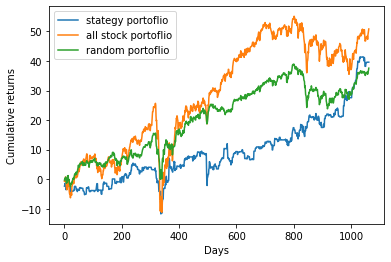

In [12]:
plt.plot(ret_strat_ptf.cumsum()*100, label='stategy portoflio')
plt.plot(all_stock_ret_ptf.cumsum()*100, label='all stock portoflio')
plt.plot(random_ptf_ret.cumsum()*100, label='random portoflio')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Cumulative returns')

In [13]:
# Risk free asset
rf = pd.read_csv("10yUS.csv")[['Date', 'Close']]
rf.Date = pd.to_datetime(rf.Date)
rf.columns = ['Date', '10yUS']
rf.set_index('Date', inplace=True)
rf = rf.groupby(rf.index.year).mean()

In [14]:
# Compute Sharpe ratio of LSTM strategy
stat_strat = StatPtf(strat_ptf.copy(), rf)
stat_strat.compute_sharpe_per_year()

In [15]:
# Compute Sharpe ratio of all stock ptf
stat_as = StatPtf(all_stock_ptf.copy(), rf)
stat_as.compute_sharpe_per_year()

In [16]:
# Compute Sharpe ratio of random portfolio
stat_random = StatPtf(random_ptf.copy(), rf)
stat_random.compute_sharpe_per_year()

In [17]:
stats = stat_as.table.merge(stat_random.table, on='years').merge(stat_strat.table, on = 'years')
stats.columns = ['Years','All Stock Sharpe Ratio', 'Random ptf Sharpe Ratio', 'LSTM ptf Sharpe Ratio']
stats

,Years,All Stock Sharpe Ratio,Random ptf Sharpe Ratio,LSTM ptf Sharpe Ratio
0,2018,-0.073354,-0.066255,-0.082948
1,2019,0.263713,0.212755,0.123271
2,2020,0.046662,0.108913,-0.016986
3,2021,0.223287,0.231985,0.176455
4,2022,-0.070814,-0.082315,0.238868
5,2023,-0.025419,-0.085372,-inf
